# Some statistics and exploration of the results

In [ ]:
import matplotlib.pyplot as plt
from indexing import SqliteInvertedIndex
import recommender
from recommender import jacard_similarity, cosine_similarity
import numpy as np

In [ ]:
inverted_index = SqliteInvertedIndex("inverted_index.db")
inverted_index_matrix = inverted_index.get_tf_idf_matrix()

query = lambda query_text: inverted_index.cursor.execute(query_text)

## Number of documents

In [1]:
query("select count(*) from documents").fetchone()

(1000,)

### Number of terms

In [2]:
query("select count(*) from terms").fetchone()

(122442,)

### Top 20 frequently occuring terms which length is greater than 3

In [3]:
res = query(
    """
    select term, sum(count) 
    from postings p 
    join terms t on p.term_id = t.id 
    group by term 
    having length(term) > 3 
    order by sum(count) desc
    limit 10
            """
)
res.fetchall()

[('shrew', 32304),
 ('retrieved', 12532),
 ('edit', 11249),
 ('function', 8687),
 ('group', 7340),
 ('archived', 7065),
 ('isbn', 6994),
 ('original', 6920),
 ('also', 6454),
 ('space', 5995)]

Despite weirdness of _shrew_, and manually checking, it turns out that _shrew_ __indeed is__ a frequent word in the documents related to mammals and other animals

### Terms with lowest entropy

In [4]:
query(
    """
        select term, idf from terms order by idf asc limit 10
        """
).fetchall()

[('retrieved', 0.0),
 ('http', 0.0),
 ('1', 0.027371196796131977),
 ('reference', 0.0460439385014068),
 ('edit', 0.07257069283483537),
 ('2', 0.1031407589195134),
 ('also', 0.14271630220159526),
 ('3', 0.16605458433008263),
 ('new', 0.2033409240180301),
 ('see', 0.21072103131565253)]

### Terms with highest entropy

In [5]:
query(
    """
  select term, idf from terms order by idf desc limit 10
  """
).fetchall()

[('combable', 6.907755278982137),
 ('ℝ3', 6.907755278982137),
 ('idealizes', 6.907755278982137),
 ('meteorologically', 6.907755278982137),
 ('accomplishes', 6.907755278982137),
 ('gidea', 6.907755278982137),
 ('1584882530', 6.907755278982137),
 ('abbildung', 6.907755278982137),
 ('bormashenko', 6.907755278982137),
 ('kazachkov', 6.907755278982137)]

### Distribution of terms occurance among all documents

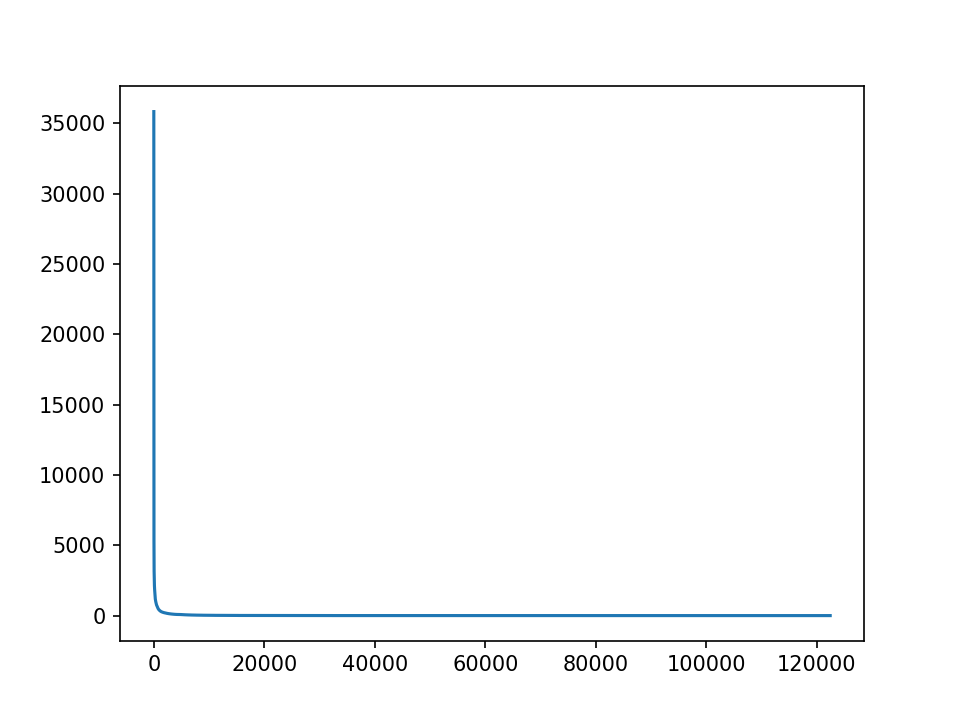

In [6]:
res = query(
    """
        select t.term, sum(p.count) 
        from terms t join postings p on t.id = p.term_id 
        group by t.term
        order by sum(p.count) desc
    """
).fetchall()

plt.plot([x[1] for x in res])

### Checking if corpus fulfills Zipf's law

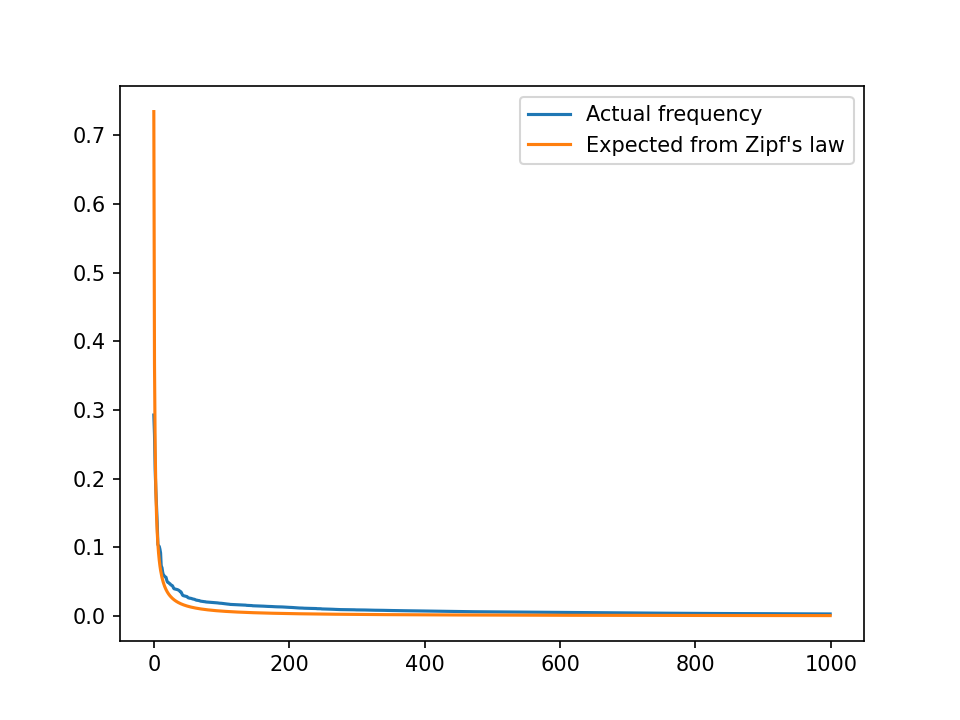

In [7]:
res = query(
    """
    select t.term, sum(p.count)
    from terms t join postings p on t.id = p.term_id
    group by t.term
    order by sum(p.count) desc
    """
).fetchall()

ocurrances = np.array([x[1] for x in res])
N = len(ocurrances)
k = ocurrances[3] / N * 4
expected_zipf = k / np.arange(1, N + 1)

cut_off = 1000
plt.plot(ocurrances[:1000] / N)
plt.plot(expected_zipf[:1000])
plt.legend(["Actual frequency", "Expected from Zipf's law"])

### Document most similar to **Open set**

In [8]:
url = "https://en.wikipedia.org/wiki/Open_set"
doc_id = inverted_index.get_document_id(url)
assert doc_id is not None

doc_vector = inverted_index_matrix[doc_id, :]

similarities = np.apply_along_axis(
    lambda x: cosine_similarity(doc_vector, x), 1, inverted_index_matrix
)

top_5_similarities = np.argsort(similarities, axis=0)[-6:-1]

for doc_id in top_5_similarities[::-1]:
    res = query(
        f"""
        select title from documents where id = {doc_id}
        """,
    ).fetchone()
    assert res is not None
    print(f"Title: {res[0]}")
    print(f"Cosine similarity: {similarities[doc_id]}\n")

Title: Closed set
Cosine similarity: 0.12982074519573655

Title: List of general topology topics
Cosine similarity: 0.10075506192466094

Title: General topology
Cosine similarity: 0.0913297495773876

Title: Interior (topology)
Cosine similarity: 0.08036750831064099

Title: Tychonoff's theorem
Cosine similarity: 0.07766889983377978



### Least similar document to **Open set**

In [9]:
url = "https://en.wikipedia.org/wiki/Open_set"
doc_id = inverted_index.get_document_id(url)
assert doc_id is not None

doc_vector = inverted_index_matrix[doc_id, :]

similarities = np.apply_along_axis(
    lambda x: cosine_similarity(doc_vector, x), 1, inverted_index_matrix
)

top_5_similarities = np.argsort(similarities, axis=0)[:5]

for doc_id in top_5_similarities:
    res = query(
        f"""
        select title from documents where id = {doc_id}
        """,
    ).fetchone()
    assert res is not None
    print(f"Title: {res[0]}")
    print(f"Cosine similarity: {similarities[doc_id]}\n")

Title: Eastern forest hedgehog
Cosine similarity: 4.78492613074056e-06

Title: Hermann Künneth
Cosine similarity: 6.591637626777496e-06

Title: Hemiechinus
Cosine similarity: 2.0191558735474507e-05

Title: Bare-bellied hedgehog
Cosine similarity: 2.1494319426508554e-05

Title: Chacarero
Cosine similarity: 2.3582096255755227e-05



These results make sense, as Open Set relates to topics like *topology* and *closed sets*, while do not relate to topics like *hedgehogs* or *Chacarero*

Open Set:
![Open Set](./reports/imgs/open-set.png)

Closed Set (similar):
![Closed Set](./reports/imgs/closed-set.png)

Eastern forest hedgehog (not similar):
![Eastern forest hedgehog]("./reports/imgs/eastern-forest-hedgehog.jpeg")

## Comparing similiarities between various documents 

In [ ]:
hedghog_doc_url = "https://en.wikipedia.org/wiki/Hedgehog"
hedgehog_doc_id = inverted_index.get_document_id(hedghog_doc_url)
hedgehog_doc_vector = inverted_index_matrix[hedgehog_doc_id, :]
assert hedgehog_doc_vector is not None

calculus_doc_url = "https://en.wikipedia.org/wiki/Calculus"
calculus_doc_id = inverted_index.get_document_id(calculus_doc_url)
calculus_doc_vector = inverted_index_matrix[calculus_doc_id, :]
assert calculus_doc_vector is not None

derivatives_doc_url = "https://en.wikipedia.org/wiki/Derivative"
derivatives_doc_id = inverted_index.get_document_id(derivatives_doc_url)
derivatives_doc_vector = inverted_index_matrix[derivatives_doc_id, :]
assert derivatives_doc_vector is not None

### Cosine similarity and Jacard similarity between hedgehog and calculus 

In [10]:
cosine_similarity_score = cosine_similarity(hedgehog_doc_vector, calculus_doc_vector)
jacard_similarity_score = jacard_similarity(hedgehog_doc_vector, calculus_doc_vector)

print("Hedgehog vs Calculus")
print(f"Cosine similarity: {cosine_similarity_score}")
print(f"Jacard similarity: {jacard_similarity_score}")

Hedgehog vs Calculus
Cosine similarity: 0.0032115008392753935
Jacard similarity: 0.09222133119486768


### Cosine similarity and Jacard similarity between calculus and derivatives

In [11]:
cosine_similarity_score = cosine_similarity(calculus_doc_vector, derivatives_doc_vector)
jacard_similarity_score = jacard_similarity(calculus_doc_vector, derivatives_doc_vector)
print("Calculus vs Derivatives")
print(f"Cosine similarity: {cosine_similarity_score}")
print(f"Jacard similarity: {jacard_similarity_score}")

Calculus vs Derivatives
Cosine similarity: 0.05259067161188228
Jacard similarity: 0.27006722024515617


Cosine similarity between derivatives and hedgehog is almost **two order of magnitude higher** than the cosine similarity between hedgehog and calculus, what should be expected